In [1]:
import warnings

import pandas as pd

# warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")
import janitor
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from utilities.graph_utils import save_mpl_fig
from utilities.utils import get_fulldata, pandas_to_tex, process_land_area

sns.set_theme(context="notebook", font_scale=1.5, style="whitegrid")

fp_religion = "../data/hindi_names_religion.csv.gz"

/home/lsys/land/venv_land/lib/python3.10/site-packages/matplotlib/_fontconfig_pattern.py:88: DeprecationWarning: 'parseString' deprecated - use 'parse_string'
  parse = parser.parseString(pattern)
/home/lsys/land/venv_land/lib/python3.10/site-packages/matplotlib/_fontconfig_pattern.py:92: DeprecationWarning: 'resetCache' deprecated - use 'reset_cache'
  parser.resetCache()
/home/lsys/land/venv_land/lib/python3.10/site-packages/matplotlib/_fontconfig_pattern.py:88: DeprecationWarning: 'parseString' deprecated - use 'parse_string'
  parse = parser.parseString(pattern)
/home/lsys/land/venv_land/lib/python3.10/site-packages/matplotlib/_fontconfig_pattern.py:92: DeprecationWarning: 'resetCache' deprecated - use 'reset_cache'
  parser.resetCache()
/home/lsys/land/venv_land/lib/python3.10/site-packages/matplotlib/_fontconfig_pattern.py:88: DeprecationWarning: 'parseString' deprecated - use 'parse_string'
  parse = parser.parseString(pattern)
/home/lsys/land/venv_land/lib/python3.10/site-packa

In [2]:
usecols = ["account_no", "caste", "name_of_ryot", "6", "7", "8"]
df = (
    get_fulldata(usecols=usecols, low_memory=False)
    .pipe(process_land_area)
    # Merge religion by hindi name
    .merge(
        (
            pd.read_csv(fp_religion, usecols=["name", "pred_label"])
            .drop_duplicates(["name"])
            .rename_column("name", "name_of_ryot")
            .rename_column("pred_label", "religion")
        ),
        how="inner",
        on="name_of_ryot",
        validate="m:1",
    )
    .assign(muslim=lambda df_: np.where(df_["religion"] == "muslim", 1, 0))
)
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33377090 entries, 0 to 33377089
Data columns (total 9 columns):
 #   Column        Dtype  
---  ------        -----  
 0   name_of_ryot  object 
 1   caste         object 
 2   account_no    int64  
 3   acres         float64
 4   decimals      float64
 5   hectare       float64
 6   tt_area_acre  float64
 7   religion      object 
 8   muslim        int64  
dtypes: float64(4), int64(2), object(3)
memory usage: 2.2+ GB


,name_of_ryot,caste,account_no,acres,decimals,hectare,tt_area_acre,religion,muslim
0,कपिलदेव पाठक,ब्रहामण,1801010001000002,0.0,66.0,0.0,0.66,not-muslim,0
1,कपिलदेव पाठक,ब्रहामण,1801010001000002,0.0,8.0,0.0,0.08,not-muslim,0
2,कपिलदेव पाठक,ब्रहामण,1801010001000002,0.0,6.0,0.0,0.06,not-muslim,0
3,कपिलदेव पाठक,ब्रहामण,1801010001000002,0.0,3.0,0.0,0.03,not-muslim,0
4,कपिलदेव पाठक,ब्रहामण,1801010001000002,0.0,36.0,0.0,0.36,not-muslim,0
...,...,...,...,...,...,...,...,...,...
33377085,सुर्य भगत,कोइरी,1402151675000036,0.0,5.0,0.0,0.05,not-muslim,0
33377086,सुर्य भगत,कोइरी,1402151675000036,0.0,5.0,0.0,0.05,not-muslim,0
33377087,रामरित भगत,कोइरीनी,1402151675000028,0.0,37.0,0.0,0.37,not-muslim,0
33377088,रामरित भगत,कोइरीनी,1402151675000028,0.0,33.0,0.0,0.33,not-muslim,0


In [3]:
df["name_of_ryot"].nunique()

2376604

In [4]:
df["account_no"].nunique()

9978187

In [5]:
100 * len(df.query("muslim==0")) / len(df.dropna(subset=["muslim"]))

91.20925461147152

In [6]:
100 * len(df.query("muslim==1")) / len(df.dropna(subset=["muslim"]))

8.790745388528478

In [7]:
table = df.groupby("muslim").agg({"muslim": "count"})
table = table / table.sum() * 100
table

,muslim
muslim,
0,91.209255
1,8.790745


## Summary numbers

In [8]:
# Land plots are owned by muslim
n_land_muslim = len(df.query("religion=='muslim'"))
perc_land_muslim = 100 * n_land_muslim / len(df)

print(f"{n_land_muslim:,.0f} ({perc_land_muslim:.1f}%) land plots are owned by muslim")

2,934,095 (8.8%) land plots are owned by muslim


In [9]:
df_num_plots = (
    df.groupby(["account_no", "religion"])
    .size()
    .reset_index()
    .rename_column(0, "nplots")
)
df_num_plots.head(3)

,account_no,religion,nplots
0,101010273000001,not-muslim,2
1,101010273000002,not-muslim,8
2,101010273000003,not-muslim,1


In [10]:
n_accounts_muslim = len(df_num_plots.query("religion=='muslim'"))
perc_accounts_muslim = 100 * n_accounts_muslim / len(df_num_plots)

print(
    f"{n_accounts_muslim:,.0f} ({perc_accounts_muslim:.1f}%) accounts are under muslim"
)

1,212,840 (12.2%) accounts are under muslim


## Number of plots per account, by religion

In [11]:
df_num_plots

,account_no,religion,nplots
0,101010273000001,not-muslim,2
1,101010273000002,not-muslim,8
2,101010273000003,not-muslim,1
3,101010273000004,not-muslim,3
4,101010273000005,not-muslim,3
...,...,...,...
9978182,3801050341000056,not-muslim,1
9978183,3801050341000057,not-muslim,1
9978184,3801050341000058,not-muslim,1
9978185,3801050341000059,not-muslim,1


In [12]:
# Get table of percentiles (fold cell)
ntiles = [
    0.0,
    0.1,
    0.2,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.8,
    0.9,
    0.95,
    0.96,
    0.97,
    0.98,
    0.99,
    1,
]
tab_nplot_perc_nonmuslim = (
    df_num_plots.query("religion=='not-muslim'")
    .nplots.quantile(ntiles)
    .reset_index()
    .rename_column("index", "Percentile")
    .rename_column("nplots", "nplots_nonmuslim")
    .astype({"nplots_nonmuslim": int})
)
tab_nplot_perc_muslim = (
    df_num_plots.query("religion=='muslim'")
    .nplots.quantile(ntiles)
    .reset_index()
    .rename_column("index", "Percentile")
    .rename_column("nplots", "nplots_muslim")
    .astype({"nplots_muslim": int})
)
tab_nplot_perc = tab_nplot_perc_muslim.merge(
    tab_nplot_perc_nonmuslim, on="Percentile", how="left", validate="1:1"
).assign(
    nplots_muslim=lambda df: df.nplots_muslim.map("{:,.0f}".format),
    nplots_nonmuslim=lambda df: df.nplots_nonmuslim.map("{:,.0f}".format),
)
pandas_to_tex(
    tab_nplot_perc,
    "../tables/percentiles_landplots_per_accountholder_religion_pranaam",
    float_format="%.2f",
)
tab_nplot_perc

,Percentile,nplots_muslim,nplots_nonmuslim
0,0.00,1,1
1,0.10,1,1
2,0.20,1,1
3,0.30,1,1
4,0.40,1,1
5,0.50,1,1
6,0.60,1,2
7,0.70,2,2
8,0.80,3,4
9,0.90,5,7


In [13]:
LINESTYLES = ["-", "--"]
DISPLOT_OPTS = dict(
    aspect=1.5,
    height=6,
    hue="religion",
    legend=False,
    palette="cividis",
    linewidth=2.5,
)
HISTDENSITY_OPTS = dict(
    hue="religion",
    legend=False,
    palette="cividis",
)

LEGEND_OPTS = {
    "title": "",
    "loc": "best",
    "labels": ["Muslim", "Non-Muslim"],
    "frameon": False,
    "fontsize": 24,
    "handletextpad": 0.3,
}
# cutoff = 0.95  # percentile to trim at

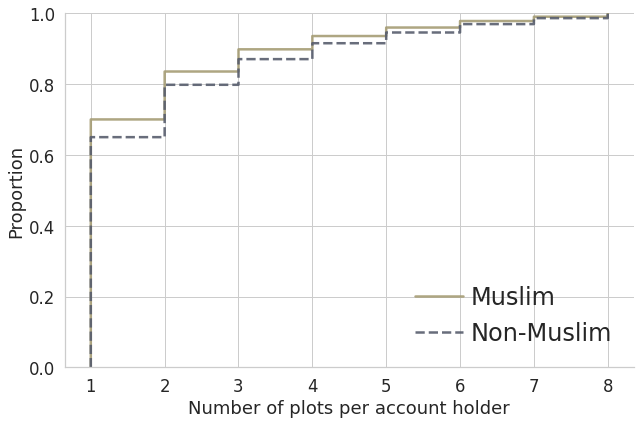

In [14]:
# Empirical CDF of #plots owned per account (fold cell)
_n = 8

g = sns.displot(
    x="nplots",
    data=df_num_plots.query(f"nplots<={_n}"),
    alpha=0.9,
    kind="ecdf",
    **DISPLOT_OPTS,
)
for line, linestyle in zip(g.axes[0][0].lines, LINESTYLES):
    line.set_linestyle(linestyle)
plt.legend(**LEGEND_OPTS)
plt.xlabel("Number of plots per account holder")
save_mpl_fig("../figures/number_plots_per_accountholder_ecdf_religion_pranaam")

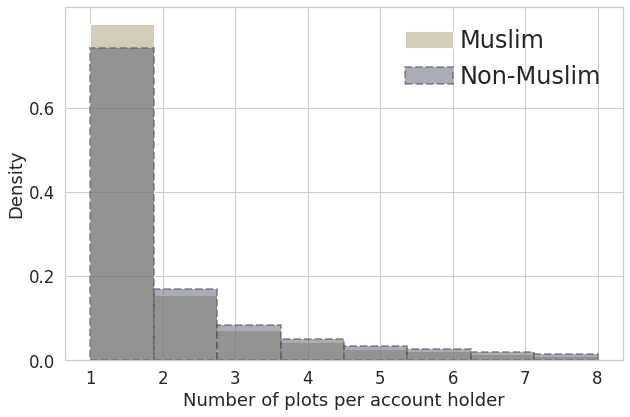

In [15]:
# Histogram of #plots owned per account (fold cell)
_, ax = plt.subplots(figsize=(10, 6.5))
sns.histplot(
    data=df_num_plots.query(f"nplots<={_n}"),
    x="nplots",
    bins=_n,
    stat="density",
    common_norm=False,
    **HISTDENSITY_OPTS,
    alpha=0.5,
    ax=ax,
)
plt.xlabel("Number of plots per account holder")
plt.yticks([0, 0.2, 0.4, 0.6])

bars = ax.containers[1].get_children()  # second set is for female
for bar in bars:
    bar.set_linestyle("--")
    bar.set_linewidth(2)
    bar.set_edgecolor("0.3")
    bar.set_alpha(0.5)
plt.legend(**LEGEND_OPTS)
save_mpl_fig("../figures/number_plots_per_accountholder_histogram_religion_pranaam")

## Land area per account, by religion

In [16]:
df_landarea = df.groupby(["account_no", "religion"])["tt_area_acre"].sum().reset_index()
df_landarea.head(3)

,account_no,religion,tt_area_acre
0,101010273000001,not-muslim,0.585
1,101010273000002,not-muslim,1.545
2,101010273000003,not-muslim,0.080


In [17]:
# Get table of percentiles (fold cell)
ntiles = [
    0.0,
    0.1,
    0.2,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.8,
    0.9,
    0.95,
    0.96,
    0.97,
    0.98,
    0.99,
    1,
]
tab_area_perc_nonmuslim = (
    df_landarea.query("religion=='not-muslim'")
    .tt_area_acre.quantile(ntiles)
    .reset_index()
    .rename_column("index", "Percentile")
    .rename_column("tt_area_acre", "area_nonmuslim")
)
tab_area_perc_muslim = (
    df_landarea.query("religion=='muslim'")
    .tt_area_acre.quantile(ntiles)
    .reset_index()
    .rename_column("index", "Percentile")
    .rename_column("tt_area_acre", "area_muslim")
)
tab_area_perc = tab_area_perc_muslim.merge(
    tab_area_perc_nonmuslim, on="Percentile", how="left", validate="1:1"
).assign(
    area_muslim=lambda df: df.area_muslim.map("{:,.2f}".format),
    area_nonmuslim=lambda df: df.area_nonmuslim.map("{:,.2f}".format),
)
pandas_to_tex(
    tab_area_perc,
    "../tables/percentiles_landarea_per_accountholder_religion_pranaam",
    float_format="%.2f",
)
tab_area_perc

,Percentile,area_muslim,area_nonmuslim
0,0.00,0.00,0.00
1,0.10,0.04,0.03
2,0.20,0.08,0.07
3,0.30,0.13,0.13
4,0.40,0.21,0.21
5,0.50,0.31,0.33
6,0.60,0.46,0.50
7,0.70,0.67,0.77
8,0.80,1.06,1.25
9,0.90,2.04,2.52


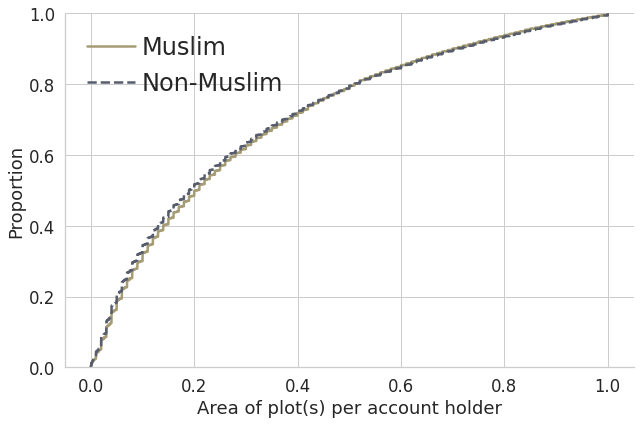

In [18]:
# Empirical CDF of land plot area owned per account (fold cell)
_area = 1
g = sns.displot(
    x="tt_area_acre",
    data=df_landarea.query(f"tt_area_acre<={_area}"),
    kind="ecdf",
    **DISPLOT_OPTS,
)
for line, linestyle in zip(g.axes[0][0].lines, LINESTYLES):
    line.set_linestyle(linestyle)
plt.legend(**LEGEND_OPTS)
plt.xlabel("Area of plot(s) per account holder")
save_mpl_fig("../figures/plot_area_per_accountholder_ecdf_religion_pranaam")

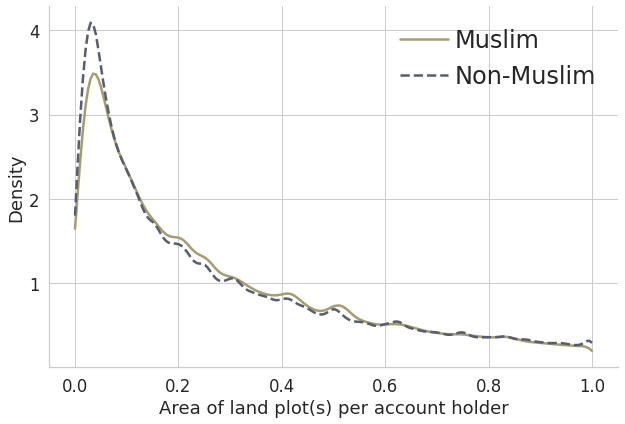

In [19]:
# Histogram of land plot area owned per account (fold cell)
g = sns.displot(
    data=df_landarea.query(f"tt_area_acre<={_area}"),
    x="tt_area_acre",
    kind="kde",
    common_norm=False,
    **DISPLOT_OPTS,
    cut=0,
)
g.set_xlabels("Area of land plot(s) per account holder")
plt.locator_params(axis="y", nbins=5)
for line, linestyle in zip(g.axes[0][0].lines, LINESTYLES):
    line.set_linestyle(linestyle)
plt.legend(**LEGEND_OPTS)
save_mpl_fig("../figures/plot_area_per_accountholder_kde_religion_pranaam")